## Name: tdop_ppi.py

Author: Robby M. Frost

University of Oklahoma

Created: 23 September 23024

Purpose: Plotting terminal doppler PPIs of radial
velocity and inferred vertical vorticity

In [6]:
import pyart
# import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd

In [7]:
# ---------------------------------
# read in radar file

# radar file location
# dfile = '/Users/robbyfrost/Documents/MS_Project/data_tmp/tokc/TOKC20240714_215057_V08'
dfile = '/home/robbyfrost/Analysis/TurbTor_Misc_Code/tokc_analysis/TOKC20240715_214211_V08'
figdir = '/home/robbyfrost/Analysis/TurbTor_Misc_Code/tokc_analysis/'

# read file
radar = pyart.io.read(dfile)
# extract radar position
radar_lat = radar.latitude['data'][0]
radar_lon = radar.longitude['data'][0]
# mask out last 10 gates of each ray, this removes the "ring" around the radar.
radar.fields["reflectivity"]["data"][:, -10:] = np.ma.masked
radar.fields["velocity"]["data"][:, -10:] = np.ma.masked
# exclude masked gates from the gridding
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_transition()
gatefilter.exclude_masked("reflectivity")
gatefilter.exclude_masked("velocity")

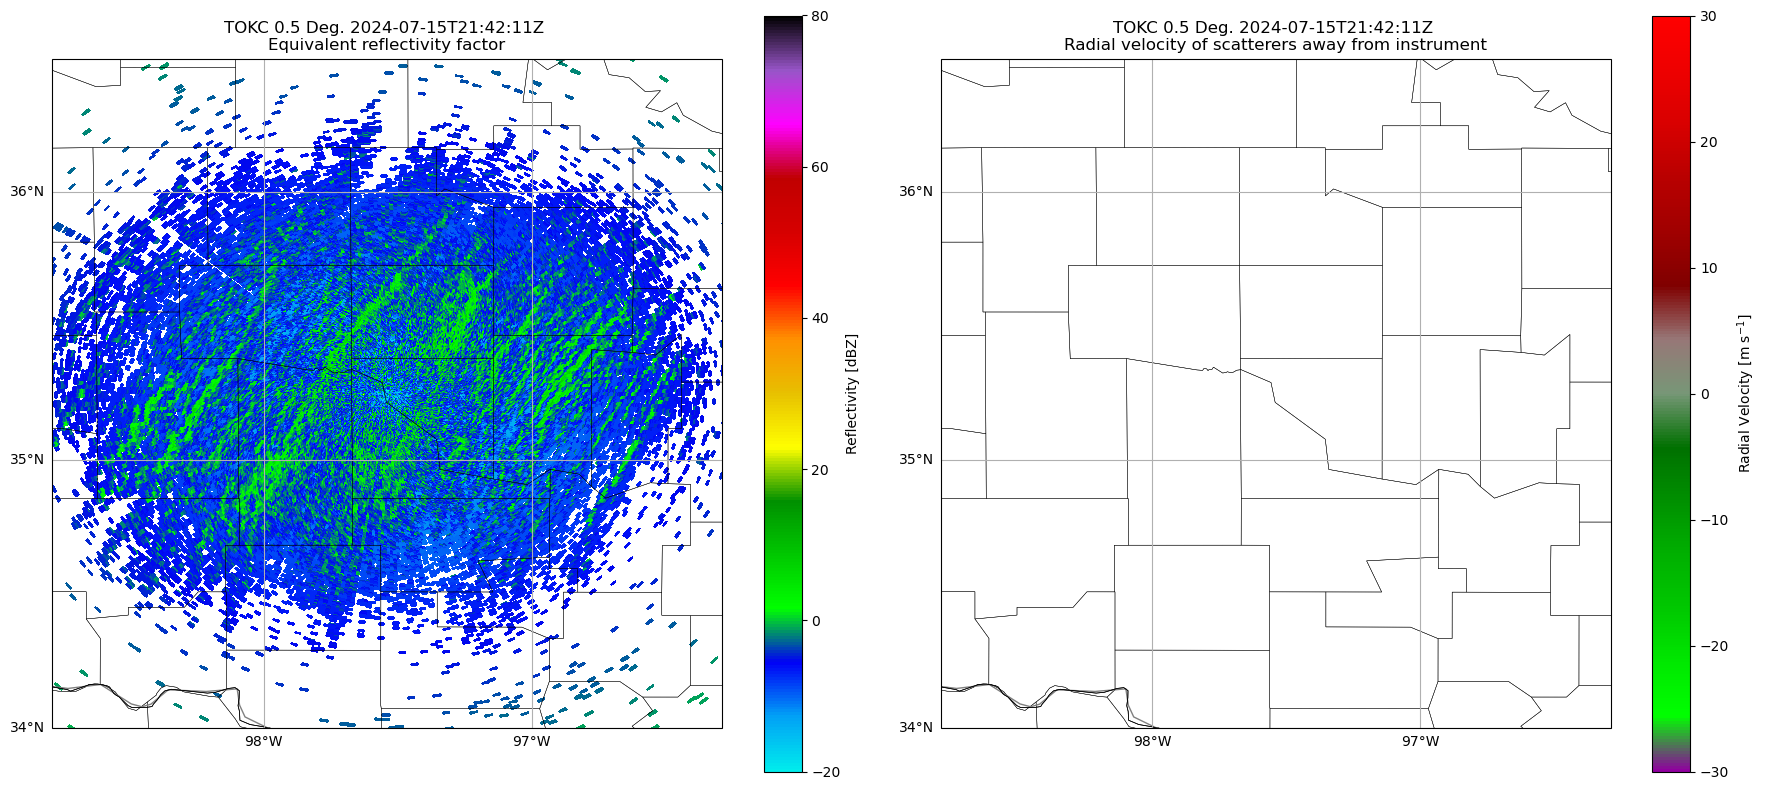

In [11]:
# ---------------------------------
# plot PPI

# Create a figure with 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# First plot: Reflectivity on ax1
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map(
    'reflectivity',
    sweep=0,
    ax=ax[0],
    cmap='pyart_NWSRef',
    vmin=-20, vmax=80,
    projection=ccrs.PlateCarree(),
    min_lon=radar_lon - 1.25, max_lon=radar_lon + 1.25,
    min_lat=radar_lat - 1.25, max_lat=radar_lat + 1.25,
    resolution='50m',
    # lat_lines=np.arange(int(radar_lat) - 2, int(radar_lat) + 2, 0.5),
    # lon_lines=np.arange(int(radar_lon) - 2, int(radar_lon) + 2, 0.5),
    colorbar_flag=True,
    colorbar_label='Reflectivity [dBZ]'
)

# Second plot: Radial Velocity on ax2
display.plot_ppi_map(
    'velocity',  # Field to plot, change as needed for your dataset
    sweep=0,
    ax=ax[1],
    cmap='pyart_NWSVel',  # Use a different colormap for velocity
    vmin=-30, vmax=30,  # Adjust min/max values for radial velocity
    projection=ccrs.PlateCarree(),
    min_lon=radar_lon - 1.25, max_lon=radar_lon + 1.25,
    min_lat=radar_lat - 1.25, max_lat=radar_lat + 1.25,
    resolution='50m',
    # lat_lines=np.arange(int(radar_lat) - 2, int(radar_lat) + 2, 0.5),
    # lon_lines=np.arange(int(radar_lon) - 2, int(radar_lon) + 2, 0.5),
    colorbar_flag=True,
    colorbar_label='Radial Velocity [m s$^{-1}$]',
    gatefilter=gatefilter
)

# mapping
for iax in ax:
    # iax.coastlines('50m')
    # iax.add_feature(cfeature.BORDERS, linewidth=1)
    iax.add_feature(cfeature.STATES, linewidth=0.5)
    geoData = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')
    geoData.plot(ax=iax, color="none", lw=0.3, aspect=1)

# Display the plot
plt.tight_layout()
plt.savefig(f"{figdir}tokc_test.png")
plt.show()
plt.close()